In [1]:
# Imports
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy
import math
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
# torch.set_default_device(device)


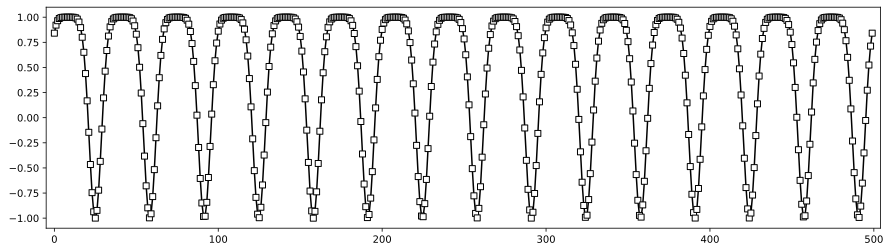

torch.Size([500])

In [2]:
# Create temporal sequence data
# Import the data
N = 500
time = torch.linspace(0, 30 * np.pi, N)

data = torch.sin(time + torch.cos(time))

plt.figure(figsize=(15, 4))
plt.plot(data.cpu(), "ks-", markerfacecolor="w")
plt.xlim([-5, N+4])
plt.show()
data.shape


In [4]:
## Create a class for the RNN DL model
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        # print(f'Input Size: {input_size}, Hidden Layers: {num_hidden}, Number of Layers: {num_layers}')
        # RNN Layers
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # Linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x, h):
        # Run through the RNN Layer
        y, hidden = self.rnn(x, h) # There will be no explicit hidden state initialization
        # And the output (linear) layer
        y = self.out(y)

        return y, hidden.detach()


In [70]:
# Network parameters
input_size = 1 # Channels of data
num_hidden = 32 # Breadth of model (Number of units in hidden layers)
num_layers = 1 # Depth of model (number of stacks of hidden layers)
seqlength = 64 # Number of datapoints used for learning in each segments
batchsize = 1 # Note: The training code is actually hard coded to organize data into batchsize=1

# Create an instance of the model
net = rnnnet(input_size, num_hidden, num_layers)
X = torch.rand(seqlength, batchsize, input_size)
y, h = net(X, None)
print('X shape: ', X.shape)
print(
    'y Shape: ', y.shape
)  # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print('h shape: ', h.shape)


X shape:  torch.Size([64, 1, 1])
y Shape:  torch.Size([64, 1, 1])
h shape:  torch.Size([1, 1, 32])


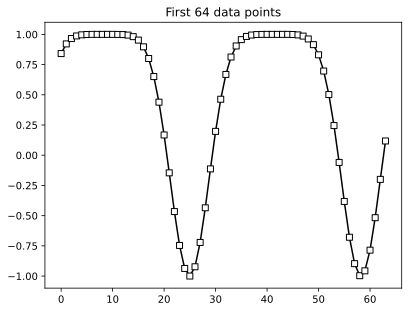

In [71]:
plt.plot(data[:seqlength].cpu(), 'ks-', markerfacecolor='w')
plt.title(f'First {seqlength} data points')
plt.show()


In [72]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1)
y = net(somedata, None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]
print(f'Final value: {finalValue}')

lossfun = nn.MSELoss()
loss = lossfun(finalValue, data[seqlength].view(1, 1))
print(f'Loss: {loss}')


Final value: tensor([[-0.2460]], grad_fn=<SelectBackward0>)
Loss: 0.41456174850463867


In [73]:
# Train the model and show performance
epochs = 50

# Create new instance of the model
net = rnnnet(input_size, num_hidden, num_layers)

optimizer = torch.optim.SGD(net.parameters(), lr=0.001)


# initialize losses
losses = np.zeros(epochs)
signaccuracy = np.zeros(epochs)

# loop over epochs
for epochi in range(epochs):

    # loop over data segments
    seglosses = []
    segacc = []
    hiddenstate = None

    for timei in range(N - seqlength):

        # grab a snippet of data
        X = data[timei : timei + seqlength].view(seqlength, 1, 1)
        y = data[timei + seqlength].view(1, 1)

        # forward pass and loss
        yHat, hiddenstate = net(X, hiddenstate)
        finalValue = yHat[-1]
        loss = lossfun(finalValue, y)  # compare final value of output

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss from this segment
        seglosses.append(loss.item())

    # average losses from this epoch
    losses[epochi] = np.mean(seglosses)

    msg = f"Finished epoch {epochi+1}/{epochs}"
    sys.stdout.write("\r" + msg)


Finished epoch 50/50

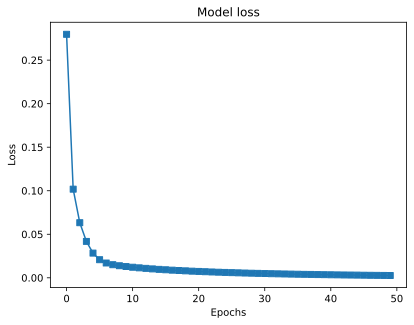

In [74]:
## let's see how the model did!

plt.plot(losses, "s-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model loss")

plt.show()


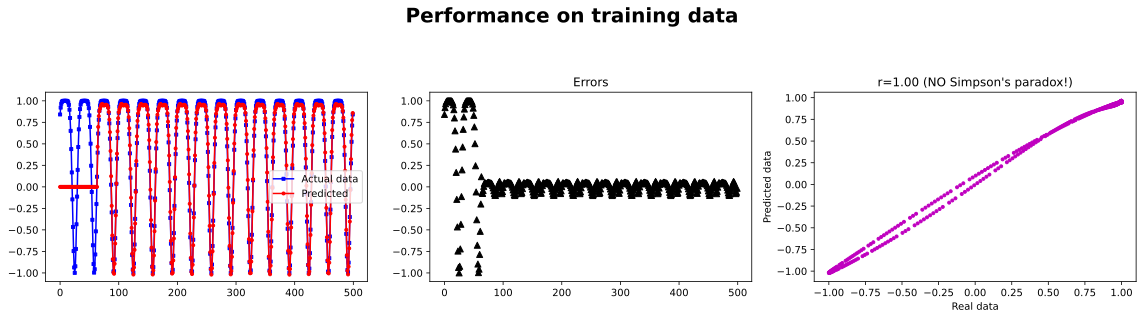

In [75]:
# initialize hidden state
h = np.zeros((N, num_hidden))
hh = None

# initialize predicted values
yHat = np.zeros(N)


# loop over time segments
for timei in range(N - seqlength):

    # grab a snippet of data
    X = data[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, hh = net(X, hh)
    yHat[timei + seqlength] = yy[-1]
    h[timei + seqlength, :] = hh.cpu().detach()


## plot!
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(data, "bs-", label="Actual data", markersize=3)
ax[0].plot(yHat, "ro-", label="Predicted", markersize=3)
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(data - yHat, "k^")
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title("Errors")

ax[2].plot(data[seqlength:], yHat[seqlength:], "mo", markersize=3)
ax[2].set_xlabel("Real data")
ax[2].set_ylabel("Predicted data")
r = np.corrcoef(data[seqlength:], yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle("Performance on training data", fontweight="bold", fontsize=20, y=1.1)
plt.tight_layout()
plt.show()


In [76]:
# # show the hidden "states" (units activations)
# plt.figure(figsize=(16, 5))

# plt.plot(h, "s-", markersize=3)
# plt.xlabel("Sequence index")
# plt.ylabel("State value (a.u.)")
# plt.title("Each line is a different hidden unit")
# plt.show()


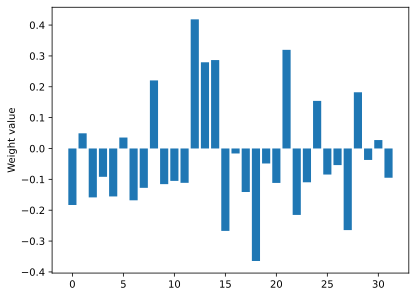

In [77]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden), net.rnn.weight_ih_l0.detach().squeeze())
plt.ylabel("Weight value")
plt.show()


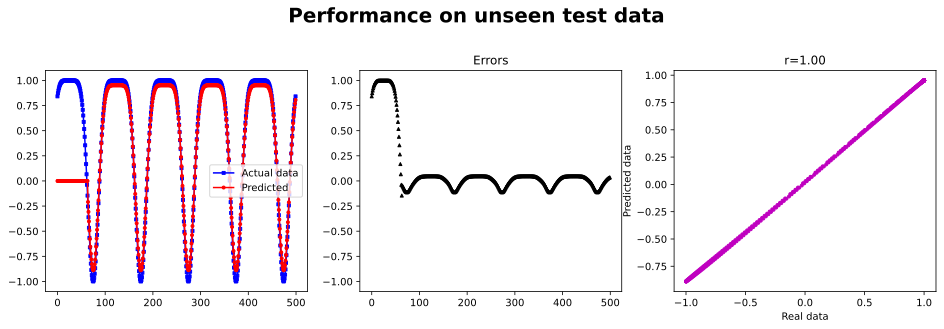

In [80]:
## Create new data (orange case: different frequency)
time = torch.linspace(0, 10 * np.pi, N)
newdata = torch.sin(time + torch.cos(time))


# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None
for timei in range(N - seqlength):

    # grab a snippet of data
    X = newdata[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss (don't need hidden states here)
    yy, h = net(X, h)
    yHat[timei + seqlength] = yy[-1]


# plotting
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(newdata, "bs-", label="Actual data", markersize=3)
ax[0].plot(yHat, "ro-", label="Predicted", markersize=3)
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(newdata - yHat, "k^", markersize=3)
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title("Errors")

ax[2].plot(newdata[seqlength:], yHat[seqlength:], "mo", markersize=3)
ax[2].set_xlabel("Real data")
ax[2].set_ylabel("Predicted data")
r = np.corrcoef(newdata[seqlength:], yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle("Performance on unseen test data", fontweight="bold", fontsize=20, y=1.1)
plt.show()


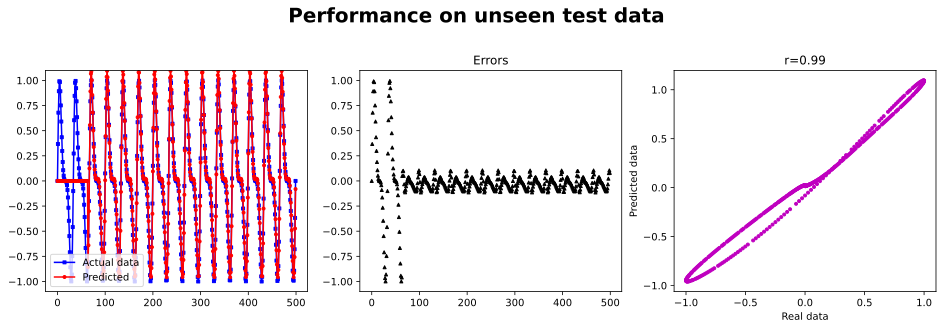

In [81]:
# Create new data (red case: different function)
time = torch.linspace(0, 30 * np.pi, N)
newdata = torch.sin(time + torch.sin(time))


# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None
for timei in range(N - seqlength):

    # grab a snippet of data
    X = newdata[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss (don't need hidden states here)
    yy, h = net(X, h)
    yHat[timei + seqlength] = yy[-1]


# plotting
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(newdata, "bs-", label="Actual data", markersize=3)
ax[0].plot(yHat, "ro-", label="Predicted", markersize=3)
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend()

ax[1].plot(newdata - yHat, "k^", markersize=3)
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title("Errors")

ax[2].plot(newdata[seqlength:], yHat[seqlength:], "mo", markersize=3)
ax[2].set_xlabel("Real data")
ax[2].set_ylabel("Predicted data")
r = np.corrcoef(newdata[seqlength:], yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle("Performance on unseen test data", fontweight="bold", fontsize=20, y=1.1)
plt.show()


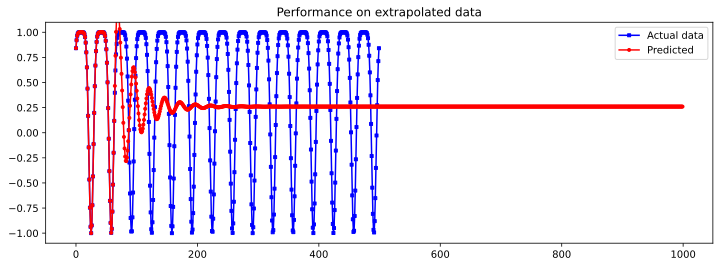

In [82]:
# using original data

# create a signal 2x as long
yHat = torch.zeros(2 * N)  # torch, not np!
yHat[:N] = data
h = None

for timei in range(2 * N - seqlength):

    # grab a snippet of data
    X = yHat[timei : timei + seqlength].view(seqlength, 1, 1)

    # forward pass and loss
    yy, h = net(X, h)
    yHat[timei + seqlength] = yy[-1]


# convert back to np for plotting
yHat = yHat.detach()

# plotting
fig = plt.figure(figsize=(12, 4))
plt.plot(data, "bs-", label="Actual data", markersize=3)
plt.plot(yHat, "ro-", label="Predicted", markersize=3)
plt.ylim([-1.1, 1.1])
plt.legend()
plt.title("Performance on extrapolated data")
plt.show()
